In [1]:
import os
import pickle
import random
import string
from collections import defaultdict

import cairo
from freetype import *
import imageio
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import PIL.ImageOps
import seaborn as sns
from scipy import ndimage
from scipy.spatial import cKDTree
from svgpathtools import Line, Path, QuadraticBezier, CubicBezier, paths2svg
import tensorflow as tf

import viz, util, fonts
from opt import Opt
from sketchnet import Sketchnet

%matplotlib inline

In [2]:
config = tf.ConfigProto(allow_soft_placement = True)
s = tf.InteractiveSession(config = config)
opt = Opt()
opt.name = 'nolocal'
# opt.chamfer_mode = 'OPTIMIZE'
opt.prepare()

In [3]:
net = Sketchnet(opt, s)
model = net.train_model

 [*] Reading checkpoint from /home/dima/Documents/research/SketchNet/output/nolocal/model/
INFO:tensorflow:Restoring parameters from /home/dima/Documents/research/SketchNet/output/nolocal/model/model-35001
     Checkpoint read from model-35001


In [4]:
fs = os.listdir(opt.pngs_dir)
model = net.test_model
random.seed(12)
random.shuffle(fs)
fs = fs[:10]
fs = ["F"+f[1:] for f in fs][0:1] + ["E"+f[1:] for f in fs][-4:-3]
images = [np.array(Image.open(opt.pngs_dir+f))[:,:,0,None]/255 for f in fs]
classes = [string.ascii_uppercase.index(f[0]) for f in fs]
# classes = [opt.class_to_template[f[0]] for f in fs]
curves = s.run(model.curves, feed_dict={model.input_images: images, model.input_classes: classes})
viz.draw_vec_fig(curves, [opt.class_to_template[f[0]] for f in fs], [f[0] for f in fs], [f[2:-4] for f in fs], opt.name+".pdf", opt, rows=2)

templates

In [ ]:
viz.draw_vec_fig(opt.templates, [opt.class_to_template[a] for a in string.ascii_uppercase], None, None, 'abc_templates.pdf', opt, rows=1)

In [6]:
viz.draw_vec_fig(opt.simple_templates, [0, 1, 2], None, None, 'abc_templates.pdf', opt, rows=1)

decorative

In [108]:
stylized = ['ArbuckleInlineNF', 'Ampad Brush', 'arcanum', 'Arty Signature',
            'ASPHALTIC SCRATCH ROUNDED PERSONAL USE', 'Lycanthrope', 'lunchds', 'MB-HorrorHouse_Font',
            'MCKLM___', 'MetropolisNF', 'RingMatrix', 'Something Fishy',
            'Springy Fancy', 'SpringRolls', 'Staccatissimo', 'starscraper']
letters = string.ascii_uppercase[:16]

images, templates, classes = [], [], []

for font, l in zip(stylized, letters):
    input_images, _, _, _, input_classes, _ = \
        net.dataset.make_random_batch(None, 1, font=font, prefix=l,
                                      indices=range(net.dataset.total_entry_count))
    
    images.append(input_images[0])
    templates.append(opt.class_to_template[l])
    classes.append(input_classes[0])

curves = s.run(model.curves, feed_dict={model.input_images: images, model.input_classes: classes})

In [109]:
viz.draw_vec_fig(curves, templates, letters, stylized, 'abc_decorative.pdf', opt, rows=4)

In [110]:
viz.draw_vec_fig(None, None, letters, stylized, 'abc_decorative_nocurves.pdf', opt)

plain

In [114]:
stylized = ['Station', 'STEINEMB', 'stentiga', 'Stilu-Oblique',
            'Tauri-Regular', 'TenorSans-Regular', 'TGL 31034-2', 'TGL 0-17 alt',
            'TheanoModern-Regular', 'Time N Space', 'TitilliumWeb-SemiBoldItalic', 'Tienne-Bold',
            'Abel-Regular', 'Aaargh', 'Acme-Regular', 'AndadaSC-Italic']
letters = string.ascii_uppercase[:16]

images, templates, classes = [], [], []

for font, l in zip(stylized, letters):
    input_images, _, _, _, input_classes, _ = \
        net.dataset.make_random_batch(None, 1, font=font, prefix=l,
                                      indices=range(net.dataset.total_entry_count))
    
    images.append(input_images[0])
    templates.append(opt.class_to_template[l])
    classes.append(input_classes[0])
        
curves = s.run(model.curves, feed_dict={model.input_images: images, model.input_classes: classes})

In [115]:
viz.draw_vec_fig(curves, templates, letters, stylized, 'abc_plain.pdf', opt, rows=4)

In [116]:
viz.draw_vec_fig(None, None, letters, stylized, 'abc_plain_nocurves.pdf', opt)

gan

In [15]:
name = 'vitesse-thin_J'
orig = Image.open('data/gan-fonts/{}.png'.format(name))
orig.thumbnail((128, 128))
im = Image.new('RGB', (128, 128))
im.paste(orig, (int((128-orig.size[0])/2),int((128-orig.size[1])/2)))
im = PIL.ImageOps.invert(im)
im.save('data/gan-fonts/{}_clean.png'.format(name))
im = util.normalize_img(np.array(im))[:,:,0,None]

In [26]:
names = ['bitessesans-blackitalic_S', 'verlagcondensed-xlightitalic_B', 'verlagcondensed-light_H',
         'vitesse-light_K']
names = ['washingtondot-lig_L', 'washingtondot-lig_P', 'worcesterroutot-med_P', 'vitesse-thin_J']

In [27]:
curves = s.run(model.curves,
  feed_dict={model.input_images:
             [util.normalize_img(np.array(Image.open('data/gan-fonts/{}_clean.png'.format(name)))[:,:,0,None])
              for name in names],
             model.input_classes: [string.ascii_uppercase.index(name[-1]) for name in names]})

In [28]:
viz.draw_gan_fig(['data/gan-fonts/{}_clean.png'.format(name) for name in names], curves,
                 [opt.class_to_template[name[-1]] for name in names], 'abc_gan2.pdf')

nearest neighbor

In [6]:
nn = [('B', 20), ('B', 26), ('B', 34), ('B', 37), ('O', 9), ('O', 4), ('O', 7235), ('O', 13)]

In [ ]:
net.dataset.entries.sort()
for l, i in nn:
    curves_list = pickle.load(open('data/fonts_vec/{}.pickle'.format(l), 'rb'))
    tree = cKDTree([c[1] for c in curves_list])
    idxs = [i for i in range(net.dataset.total_entry_count) if net.dataset.entries[i][0] == l]
    
    k = 8
    _, nn_idxs = tree.query(curves_list[i][1], k=k)
    fonts = [net.dataset.entries[curves_list[i][0]][2:] for i in nn_idxs]
    viz.draw_vec_fig(Non]e, [opt.class_to_template[l]]*k, [l]*k, fonts, 'abc_nn_{}{}.pdf'.format(l, i), opt,
                colors=[(44/255,160/255,44/255)] + [(0,0,0)]*(k-1), rows=1)
    
    _, nn_idxs = zip(*net.dataset.get_chamfer_knn(curves_list[i][0], k, idxs=idxs))
    fonts = [net.dataset.entries[i][2:] for i in nn_idxs]
    viz.draw_vec_fig(None, [opt.class_to_template[l]]*k, [l]*k, fonts, 'abc_nn_{}{}_base.pdf'.format(l, i), opt,
                    colors=[(44/255,160/255,44/255)] + [(0,0,0)]*(k-1), rows=1)

/home/dima/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dima/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
net.dataset.entries.sort()
for l in string.ascii_uppercase:
    print('Processing {}...'.format(l))
    curves_list = []
    idxs = [i for i, d in enumerate(net.dataset.entries) if d.startswith(l)]
    for i in range(0, len(idxs)-1, 200):
        if i % 2000 == 0: print("{} out of {}".format(i, len(idxs)))
        images, _, _, _, classes, _ = net.dataset.make_random_batch(None, len(idxs[i:i+200]), indices=idxs[i:i+200])
        curves = s.run(model.curves, feed_dict={model.input_images: images, model.input_classes: classes})
        for j in range(len(idxs[i:i+200])):
            curves_list.append((idxs[i+j], curves[j]))
    pickle.dump(curves_list, open('data/fonts_vec/{}.pickle'.format(l), 'wb'))

exploration

In [259]:
l = 'A'
curves_list = pickle.load(open('data/fonts_vec/{}.pickle'.format(l), 'rb'))
tree = cKDTree([c[1] for c in curves_list])

In [314]:
n = 1
curve = curves_list[50][1].copy()
_, i = tree.query(curve)
fonts = [net.dataset.entries[curves_list[i][0]][2:]]
curves = [curve]
viz.draw_vec_fig(curves, [opt.class_to_template[l]]*n, [l]*n, fonts, 'test1.pdf', opt)

In [315]:
curve[37:50:2] += 0.1
curve[75] += 0.15
curve[60] -= 0.05
curve[61] += 0.15
_, i = tree.query(curve)
fonts = [net.dataset.entries[curves_list[i][0]][2:]]
curves = [curve]
viz.draw_vec_fig(curves, [opt.class_to_template[l]]*n, [l]*n, fonts, 'test2.pdf',
                 opt, marked_verts=[(curve[i], curve[i+1]) for i in list(range(36, 51, 2)) + [74, 75, 60, 61]])

In [316]:
curve[9:18:2] += 0.05
_, i = tree.query(curve)
fonts = [net.dataset.entries[curves_list[i][0]][2:]]
curves = [curve]
viz.draw_vec_fig(curves, [opt.class_to_template[l]]*n, [l]*n, fonts, 'test3.pdf',
                 opt, marked_verts=[(curve[i], curve[i+1]) for i in list(range(10, 19, 2))])

In [317]:
curve[60:76] = [0.5 , 0.49206068, 0.48 , 0.551968 , 0.46,
       0.59 , 0.6452322, 0.5838341 , 0.63858575, 0.5698419 ,
       0.6458497 , 0.5604253 , 0.61376965, 0.44271457, 0.595784  ,
       0.32159513]
_, i = tree.query(curve)
fonts = [net.dataset.entries[curves_list[i][0]][2:]]
curves = [curve]
viz.draw_vec_fig(curves, [opt.class_to_template[l]]*n, [l]*n, fonts, 'test4.pdf',
                 opt, marked_verts=[(curve[i], curve[i+1]) for i in list(range(10, 19, 2))])

interpolation

In [98]:
l = 'C'
curves_list = pickle.load(open('data/fonts_vec/{}.pickle'.format(l), 'rb'))
tree = cKDTree([c[1] for c in curves_list])

In [99]:
curve2 = curves_list[6][1]
curve1 = curves_list[13][1]
fonts = []

for i in range(200):
    curve = i/199*curve1 + (199-i)/199*curve2
    _, i = tree.query(curve)
    font = net.dataset.entries[curves_list[i][0]][2:]
    if font not in fonts:
        fonts.append(font)

n = len(fonts)
viz.draw_vec_fig(None, [opt.class_to_template[l]]*n, [l]*n, fonts, 'interpolation3.pdf', opt, rows=1)

In [102]:
curves_list = []
letter_lookup = {}
i = 0
for l in string.ascii_uppercase:
    letter_lookup[i] = l
    curves = pickle.load(open('data/fonts_vec/{}.pickle'.format(l), 'rb'))
    curves_list.extend(curves)
    for j in range(i, i+len(curves)):
        letter_lookup[j] = l
        i += 1
tree = cKDTree([c[1] for c in curves_list])

In [133]:
letter_lookup[100000]

'K'

In [144]:
curve2 = curves_list[100003][1]
curve1 = curves_list[78844][1]
t = opt.class_to_template['K']
fonts = []

letters = []
for i in range(200):
    curve = i/199*curve1 + (199-i)/199*curve2
    _, i = tree.query(curve)
    font = net.dataset.entries[curves_list[i][0]][2:]
    if font not in fonts and opt.class_to_template[letter_lookup[curves_list[i][0]]] == t:
        fonts.append(font)
        letters.append(letter_lookup[curves_list[i][0]])
        

n = len(fonts)
viz.draw_vec_fig(None, [opt.class_to_template[l] for l in letters], letters, fonts, 'abc_interpolation7.pdf', opt, rows=1)

editing

In [723]:
def distance_to_curves(source_points, curves):
    curves = tf.reshape(curves, [-1, 3, 2])  # [n_curves, 3, 2]
    n_curves_predicted = tf.shape(curves)[0]
    n_source_points = tf.shape(source_points)[0]

    p0, p1, p2 = tf.split(curves, 3, axis=1)  # [n_curves, 1, 2]
    X = p1 - p0  # [n_curves, 1, 2]
    Y = p2 - p1 - X  # [n_curves, 1, 2]
    Z = p0 - source_points[None,:,:]  # [n_curves, n_points, 2]

    a = tf.reduce_sum(Y*Y, axis=2)  # [n_curves, 1]
    safe_a = tf.where(tf.less(tf.abs(a), 1e-6), tf.ones_like(a), a)
    b = 3*tf.reduce_sum(X*Y, axis=2)  # [n_curves, 1]
    c = 2*tf.reduce_sum(X*X, axis=2) + tf.reduce_sum(Y*Z, axis=2)  # [n_curves, n_points]
    d = tf.reduce_sum(X*Z, axis=2)  # [n_curves, n_points]

    A = b/safe_a
    B = c/safe_a
    C = d/safe_a

    Q = (A**2 - 3*B) / 9
    sqrt_Q = tf.sqrt(tf.abs(Q) + 1e-6)
    R = (2*A**3 - 9*A*B + 27*C) / 54

    safe_sqrt_Q = tf.where(tf.less(sqrt_Q, 1e-6), tf.ones_like(sqrt_Q), sqrt_Q)
    theta = tf.acos(tf.clip_by_value(R / safe_sqrt_Q**3, -1+1e-6, 1-1e-6))
    t1 = -2 * safe_sqrt_Q * tf.cos(theta/3) - A/3

    t2 = -2 * safe_sqrt_Q * tf.cos((theta+2*np.pi)/3) - A/3
    t3 = -2 * safe_sqrt_Q * tf.cos((theta+4*np.pi)/3) - A/3

    alpha = -tf.sign(R) * (tf.abs(R) + tf.sqrt(tf.abs(R**2-Q**3) + 1e-6)) ** (1/3)
    safe_alpha = tf.where(tf.less(tf.abs(alpha), 1e-6), tf.ones_like(alpha), alpha)
    beta = tf.where(tf.less(tf.abs(alpha), 1e-6), tf.zeros_like(Q), Q/safe_alpha)

    t4 = alpha + beta - A/3

    safe_c = tf.where(tf.less(tf.abs(c), 1e-6), tf.ones_like(c), c)
    t5 = -d/safe_c

    ts = tf.stack((t1, t2, t3, t4, t5, tf.zeros_like(t1), tf.ones_like(t1)), axis=2)  # [n_curves, n_points, 5]
    ts = tf.clip_by_value(ts, 0, 1)

    points = tf.reshape(ts, [n_curves_predicted, -1])  # [n_curves, n_points*5]
    points = tf.transpose(tf.pow(points, tf.constant([0, 1., 2])[:,None,None]), [1, 2, 0])  # [n_curves, n_points*5, 3]

    A = tf.tile(tf.constant([[[1., 0, 0],
                              [-2, 2, 0],
                              [1, -2, 1]]]), [n_curves_predicted, 1, 1])  # [n_curves, 3, 3]

    points = tf.matmul(tf.matmul(points, A), curves)  # [n_curves, n_points*5, 2]
    points = tf.reshape(points, [n_curves_predicted, n_source_points, 7, 2])  # [n_curves, n_points, 5, 2]

    distances = tf.sqrt(tf.reduce_sum((points-source_points[None,:,None,:])**2, axis=3))
    ds = distances
    
    ds = tf.transpose(ds, (1, 0, 2))
    ts = tf.transpose(ts, (1, 0, 2))
    
    shape = ts.shape.as_list()
    xy_ind = tf.stack(tf.meshgrid(tf.range(shape[0]), tf.range(shape[1]),
                              indexing='ij'), axis=-1)
    gather_ind = tf.concat([xy_ind, tf.argmin(ds, axis=-1, output_type=tf.int32)[..., None]], axis=-1)
    ts = tf.gather_nd(ts, gather_ind)
    ds = tf.reduce_min(ds, axis=-1)

    return ts, ds

In [530]:
def evaluate_bezier(curves, ts):
    curves = tf.reshape(curves, [-1, 3, 2])  # [n_curves, 3, 2]
    points = tf.reshape(ts, [tf.shape(curves)[0], -1])  # [n_curves, n_ts]
    points = tf.transpose(tf.pow(points, tf.constant([0, 1., 2])[:,None,None]), [1, 2, 0])  # [n_curves, n_ts, 3]

    A = tf.tile(tf.constant([[[1., 0, 0],
                              [-2, 2, 0],
                              [1, -2, 1]]]), [tf.shape(curves)[0], 1, 1])  # [n_curves, 3, 3]

    points = tf.matmul(tf.matmul(points, A), curves)  # [n_curves, n_ts, 2]
    return points

In [760]:
def move_points(points, curves, new_curves):
    if curves is None or new_curves is None: return np.array(points)
    curves = tf.reshape(tf.constant(curves, dtype=tf.float32), [-1, 6])
    new_curves = tf.reshape(tf.constant(new_curves, dtype=tf.float32), [-1, 6])
    points = tf.constant(points, dtype=tf.float32)
    ts, ds = distance_to_curves(points, curves)
    ts = tf.transpose(ts)
 
    Ts = tf.transpose(evaluate_bezier(new_curves, ts), (1, 0, 2)) - \
        tf.transpose(evaluate_bezier(curves, ts), (1, 0, 2))
    ds = 1 / (ds**2 + 1e-15)
    ds = ds / tf.reduce_sum(ds, axis=-1, keepdims=True)
    Ts = Ts * ds[...,None]
    Ts = tf.reduce_sum(Ts, axis=1)

    return (points+Ts).eval()

In [793]:
def draw_glyph(font, char, ctx, color=(0.6, 0.6, 0.6), curves=None, new_curves=None, offset=(0,0)):
    try:
        face = Face('data/fonts/ttfs/{}.ttf'.format(font))
    except:
        face = Face('data/fonts/ttfs/{}.otf'.format(font))
    face.set_char_size(48*64)
    face.load_char(char)
    outline = face.glyph.outline
    contours = [-1] + outline.contours
    segment = []
    segments = []
    paths = []
    for i in range(len(outline.points)):
        segment.append(complex(*outline.points[i]).conjugate())
        tag = int(bin(outline.tags[i])[2])
        try:
            j = contours.index(i)
            if tag == 0:
                segment.append(complex(*outline.points[contours[j-1]+1]).conjugate())
                tag = 2
            else:
                tag = 3
        except ValueError:
            pass
        if tag > 0:
            if len(segment) == 1:
                pass
            elif len(segment) == 2:
                segments.append(Line(*segment))
            elif len(segment) == 3:
                segments.append(QuadraticBezier(*segment))
            elif len(segment) == 4:
                segments.append(CubicBezier(*segment))
            else:
                for k in range(len(segment)-1):
                    A, C = segment[k:k+2]
                    B = (A+C) / 2
                    segments.append(QuadraticBezier(A, B, C))

            if tag == 1:
                segment = [complex(*outline.points[i]).conjugate()]
            elif tag == 2:
                paths.append(Path(*segments))
                segments = []
                segment = []
            else:
                segments.append(Line(segment[-1], complex(*outline.points[contours[j-1]+1]).conjugate()))
                paths.append(Path(*segments))
                segments = []
                segment = []

    xmin, xmax, ymin, ymax = paths2svg.big_bounding_box(paths)
    factor = 0.8 / max(xmax-xmin, ymax-ymin)
    for i, path in enumerate(paths):
        paths[i] = path.translated(complex(-xmin, -ymin)).scaled(factor)
    xmin, xmax, ymin, ymax = paths2svg.big_bounding_box(paths)
    xmargin = (1 - (xmax-xmin)) / 2
    ymargin = (1 - (ymax-ymin)) / 2
    for i, path in enumerate(paths):
        paths[i] = path.translated(complex(xmargin, ymargin))

    ctx.set_source_rgb(*color)
    ctx.new_path()
    ctx.set_line_width(0.02)
    
    new_points = []
    
    for path in paths:
        points = [[path[0].bpoints()[0].real, path[0].bpoints()[0].imag]]
        for seg in path:
            bpoints = seg.bpoints()
            if len(bpoints) == 2:
                new_points.extend([[bpoints[0].real, bpoints[0].imag],
                                 [bpoints[1].real, bpoints[1].imag]])
            elif len(bpoints) == 3:
                points = [[bpoints[0].real * 1/3 + bpoints[1].real * 2/3,
                           bpoints[0].imag * 1/3 + bpoints[1].imag * 2/3],
                          [bpoints[1].real * 2/3 + bpoints[2].real * 1/3,
                           bpoints[1].imag * 2/3 + bpoints[2].imag * 1/3],
                          [bpoints[2].real, bpoints[2].imag]]
                new_points.extend(points)
            elif len(bpoints) == 4:
                points = [[bpoints[1].real, bpoints[1].imag],
                          [bpoints[2].real, bpoints[2].imag],
                          [bpoints[3].real, bpoints[3].imag]]
                new_points.extend(points)

    new_points = move_points(new_points, curves, new_curves)
    
    ctx.save()
    ctx.translate(*offset)
    for path in paths:
        ctx.move_to(*new_points[0])
        for seg in path:
            bpoints = seg.bpoints()
            if len(bpoints) == 2:
                ctx.line_to(*new_points[1])
                new_points = np.delete(new_points, [0, 1], 0)
            elif len(bpoints) == 3 or len(bpoints) == 4:
                ctx.curve_to(*new_points[0], *new_points[1], *new_points[2])
                new_points = np.delete(new_points, [0, 1, 2], 0)
    ctx.restore()
            
    ctx.fill()


In [902]:
start_fonts = ['Abduco', 'almonte snow', 'amydor', 'aftermat']
end_fonts = ['abberancy', 'absci___', 'AC_Brodie', 'adamb']

In [903]:
surface = cairo.PDFSurface('abc_analogies.pdf', 128*5, 128*5)
ctx = cairo.Context(surface)
ctx.scale(opt.img_size, opt.img_size)

for x in range(len(start_fonts)):
    input_images, _, _, _, input_classes, _ = \
        net.dataset.make_random_batch(None, 1, font=start_fonts[x], prefix='A',
                                      indices=range(net.dataset.total_entry_count))
    curves = s.run(model.curves, feed_dict={model.input_images: input_images, model.input_classes: input_classes})
    curves = viz.apply_templates(curves[0]).squeeze()[:,1]
    draw_glyph(start_fonts[x], 'A', ctx, curves=curves, offset=(x+1,0), color=(255/255,127/255,14/255))

for y in range(len(end_fonts)):
    input_images, _, _, _, input_classes, _ = \
        net.dataset.make_random_batch(None, 1, font=end_fonts[y], prefix='A',
                                      indices=range(net.dataset.total_entry_count))
    new_curves = s.run(model.curves, feed_dict={model.input_images: input_images, model.input_classes: input_classes})
    new_curves = viz.apply_templates(new_curves[0]).squeeze()[:,1]
    draw_glyph(end_fonts[y], 'A', ctx, curves=new_curves, offset=(0,y+1), color=(31/255,119/255,180/255))
    
for x in range(len(start_fonts)):
    for y in range(len(end_fonts)):
        input_images, _, _, _, input_classes, _ = \
            net.dataset.make_random_batch(None, 1, font=start_fonts[x], prefix='A',
                                          indices=range(net.dataset.total_entry_count))
        curves = s.run(model.curves, feed_dict={model.input_images: input_images, model.input_classes: input_classes})
        curves = viz.apply_templates(curves[0]).squeeze()[:,1]
        
        input_images, _, _, _, input_classes, _ = \
            net.dataset.make_random_batch(None, 1, font=end_fonts[y], prefix='A',
                                          indices=range(net.dataset.total_entry_count))
        new_curves = s.run(model.curves, feed_dict={model.input_images: input_images, model.input_classes: input_classes})
        new_curves = viz.apply_templates(new_curves[0]).squeeze()[:,1]
        
        draw_glyph(start_fonts[x], 'A', ctx, color=(0,0,0), curves=curves, new_curves=new_curves, offset=(x+1,y+1))
surface.finish()

loss viz

In [23]:
net.dataset.entries.sort()
losses = []
for i in range(0, net.dataset.total_entry_count):
    if i % 20000 == 0: print("{} out of {}".format(i, net.dataset.total_entry_count))
    images, df, af, rc, classes, templates = net.dataset.make_random_batch(None, 1, indices=[i])
    loss = s.run(model.loss,
                           feed_dict={model.input_images: images,
                                      model.target_distance_fields: df,
                                      model.target_alignment_fields: af,
                                      model.target_rendered_curves: rc,
                                      model.input_templates: templates,
                                      model.input_classes: classes})
    losses.append((loss, i))
pickle.dump(losses, open('data/fonts_vec/losses.pickle'.format(l), 'wb'))

0 out of 245843
20000 out of 245843
40000 out of 245843
60000 out of 245843
80000 out of 245843
100000 out of 245843
120000 out of 245843
140000 out of 245843
160000 out of 245843
180000 out of 245843
200000 out of 245843
220000 out of 245843
240000 out of 245843


In [57]:
losses = pickle.load(open('data/fonts_vec/losses.pickle'.format(l), 'rb'))

In [114]:
loss, i = sorted(losses)[-90]
print(loss*1e2)
l = net.dataset.entries[i][0]
images, df, af, rc, classes, templates = net.dataset.make_random_batch(None, 1, indices=[i])
curves = s.run(model.curves,
                       feed_dict={model.input_images: images,
                                  model.target_distance_fields: df,
                                  model.target_alignment_fields: af,
                                  model.target_rendered_curves: rc,
                                  model.input_templates: templates,
                                  model.input_classes: classes})
viz.draw_vec_fig(curves, [opt.class_to_template[l]], [l],
                 [net.dataset.entries[i][2:]], 'loss_1.pdf', opt, rows=1)

0.12376345694065094


In [58]:
lossvals = [l[0] * 1e3 for l in losses]

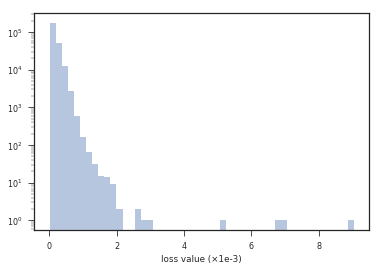

In [60]:
_, ax = plt.subplots(figsize=(6,4))
sns.set(rc={'text.usetex' : False})
sns.set_style('ticks')
sns.set_context('paper')

sns.distplot(pd.Series(lossvals, name="loss value (×1e-3)"), kde=False, hist_kws={'log':True}, ax=ax);
plt.savefig('loss_plot.png', dpi=400)

In [9]:
linspace = tf.linspace(-1/(opt.img_size-1), 1+1/(opt.img_size-1), opt.img_size+2)
grid_pts = tf.reshape(tf.stack(tf.meshgrid(linspace, linspace), axis=2), [-1, 2])
df = util.distance_to_curves(grid_pts, tf.constant([[0.2, 0.3, 0.5, 0.1, 0.7, 0.8]]), opt).eval().reshape([ opt.img_size+2,  opt.img_size+2])

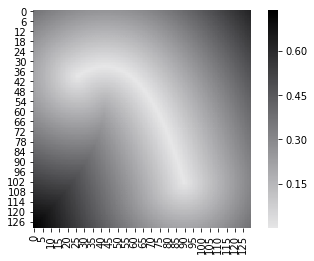

In [18]:
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(df, square=True, cmap=cmap)

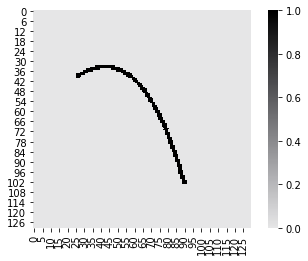

In [21]:
rc = (df<0.01).astype(np.int32)
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(rc, square=True, cmap=cmap)

In [36]:
df = tf.reshape(util.distance_to_curves(grid_pts, tf.constant([[0.2, 0.3, 0.5, 0.1, 0.7, 0.8]]), opt), [1,130,130])
af = util.compute_alignment_fields(df).eval()
af = af.squeeze()
rc = (df.eval().reshape([ opt.img_size+2,  opt.img_size+2])<0.01).astype(np.int32)


(130, 130)

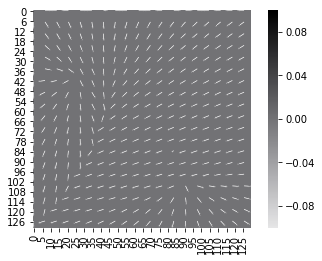

In [38]:
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(rc*0, square=True, cmap=cmap)
Y, X = np.mgrid[0:128:7, 0:128:7]
dx = np.imag(np.sqrt(af[:,:]))
dy = np.real(np.sqrt(af[:,:]))
plt.quiver(X, Y, dx[::7, ::7], -dy[::7, ::7], color='white', scale=30, headaxislength=0,)

In [5]:
surface = cairo.PDFSurface('bezier-samples.pdf', 128, 128)
ctx = cairo.Context(surface)  
ctx.scale(128,128)
ctx.set_line_width(0.04) 
ctx.set_source_rgb(0,0,0)
a = np.array([0.4, 0.1])
b= np.array([0.5, 1.5])
c = np.array([0.6, 0.1])
for t in np.linspace(0,1,20):
    p = (1-t)**2*a + 2*(1-t)*t*b + t**2*c    
    ctx.arc(p[0], p[1], 0.02, 0, 2*np.pi) 
    ctx.fill()
surface.finish()

In [9]:
from tensorboard.backend.event_processing import event_accumulator

def analyze_loss(path, name):
    event_acc = event_accumulator.EventAccumulator(path)
    event_acc.Reload()
    data = {}

    events = event_acc.Scalars(name)
    x, y, durations = [events[0].step], [events[0].value], []
    time = events[0].wall_time
    step = events[0].step
    for event in events[1:]:
        durations.append((event.wall_time - time)/(event.step-step))
        time = event.wall_time
        step = event.step
        x.append(event.step)
        y.append(event.value)
        
    print(sum(durations)/len(durations))
    return x, y

In [14]:
x, y = analyze_loss('output/main/summaries/train-20190313-153051/', 'local-loss')
# _ = analyze_loss('output/noalign/summaries/train-20190313-153505/', 'local-loss')
# x1, y1 = analyze_loss('output/noglobal/summaries/train-20190313-153534/', 'local-loss')
# _ = analyze_loss('output/nolocal/summaries/train-20190313-153523/', 'local-loss')
# _ = analyze_loss('output/chamfer/summaries/train-20190313-153851/', 'chamfer-loss')
_ = analyze_loss('output/notemplates/summaries/train-20190313-153448/', 'local-loss')

INFO:tensorflow:No path found after output/main/summaries/train-20190313-153051/events.out.tfevents.1552491064.tensorflow-1-vm
1.1194103292710615
INFO:tensorflow:No path found after output/notemplates/summaries/train-20190313-153448/events.out.tfevents.1552491304.tensorflow-2-vm
1.1268175619252676


INFO:tensorflow:No path found after output/notemplates/summaries/train-20190313-153448/events.out.tfevents.1552491304.tensorflow-2-vm
1.1268175619252676
INFO:tensorflow:No path found after output/notemplates_noglobal/summaries/train-20190314-123026/events.out.tfevents.1552581033.gomba
0.6905029728394793


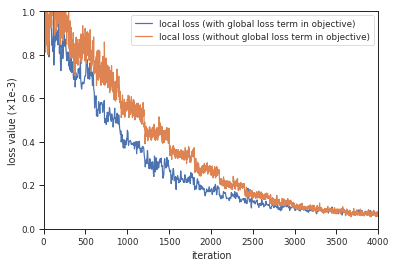

In [130]:

_ = analyze_loss('output/nolocal/summaries/train-20190313-153523/', 'local-loss')from scipy.interpolate import make_interp_spline, BSpline

xs1, ys1 = analyze_loss('output/notemplates/summaries/train-20190313-153448/', 'local-loss')
xs2, ys2 = analyze_loss('output/notemplates_noglobal/summaries/train-20190314-123026/', 'local-loss')

fig, ax = plt.subplots(figsize=(6,4))
sns.set(rc={'text.usetex' : False})
sns.set_style('ticks')
sns.set_context('paper')

def smooth(xs, ys, smoothing):
    ys_ = []
    last = ys[0]
    for y in ys:
        last = last*smoothing + y*(1-smoothing)
        ys_.append(last)
    xs_new = np.linspace(min(xs), max(xs), 10000)
    spl = make_interp_spline(xs, ys_, k=3)
    ys_new = spl(xs_new)
    return xs_new, ys_new
    



plt.ylim(top=1)
plt.xlim((0, 4000))
plt.xlabel("iteration")
plt.ylabel("loss value (×1e-3)") 
sns.lineplot(*smooth(xs1, [y*1e3 for y in ys1], 0.7), ax=ax, label="local loss (with global loss term in objective)")
sns.lineplot(*smooth(xs2, [y*1e3 for y in ys2], 0.7), ax=ax, label="local loss (without global loss term in objective)")

In [5]:
from scipy.spatial.distance import cdist
fs = ['Roboto-Regular', 'OpenSans-Regular', 'Lato-Regular', 'Montserrat-Regular', 'SourceSansPro-Regular', 'Oswald-Regular',
      'Raleway-Regular', 'Arimo-Regular', 'NotoSans-Regular', 'Ubuntu-R', 'Muli-Regular', 'TitilliumWeb-Regular',
      'Nunito-Regular', 'FiraSans-Regular', 'Dosis-Medium', 'Oxygen-Regular', 'Hind-Regular', 'Cabin-Regular-TTF',
      'LibreFranklin-Regular', 'JosefinSans-Regular']

In [8]:
loss = 0
print(opt.name)
for l in string.ascii_uppercase:
    for font in fs:
        i = string.ascii_uppercase.index(l)
        f = "{}_{}.png".format(l, font)
        images = np.array(Image.open(opt.pngs_dir+f))[None,:,:,0,None]/255
        classes = [i]
        curves = s.run(model.curves, feed_dict={model.input_images: images, model.input_classes: classes})

        points = fonts.sample_points_from_font(f[2:-4], l)
        random.shuffle(points)
        points = np.array(points[:1000])
        points_pred = fonts.sample_points_from_curves(curves[0], opt.class_to_template[l])
        random.shuffle(points_pred)
        points_pred = np.array(points_pred[:1000])

        d = cdist(points, points_pred)
        loss += np.sum(np.amin(d, axis=0))/d.shape[1]+np.sum(np.amin(d, axis=1))/d.shape[0]
print(loss/26/len(fs))

chamfer
0.012340475967275485


In [7]:
loss = 0
print(opt.name)
for l in string.ascii_uppercase:
    for font in fs:
        i = string.ascii_uppercase.index(l)
        f = "{}_{}.png".format(l, font)
        images = np.array(Image.open(opt.pngs_dir+f))[None,:,:,0,None]/255
        classes = [i]
        curves = s.run(model.curves, feed_dict={model.input_images: images, model.input_classes: classes})

        points = fonts.sample_points_from_font(f[2:-4], l)
        random.shuffle(points)
        points = np.array(points[:1000])
        points_pred = fonts.sample_points_from_curves(curves[0], opt.class_to_template[l])
        random.shuffle(points_pred)
        points_pred = np.array(points_pred[:1000])

        d = cdist(points, points_pred)
        loss += np.sum(np.amin(d, axis=0))/d.shape[1]+np.sum(np.amin(d, axis=1))/d.shape[0]
print(loss/26/len(fs))

main2
0.011859797052037147


In [6]:
loss = 0
print(opt.name)
for l in string.ascii_uppercase:
    for font in fs:
        i = string.ascii_uppercase.index(l)
        f = "{}_{}.png".format(l, font)
        images = np.array(Image.open(opt.pngs_dir+f))[None,:,:,0,None]/255
        classes = [i]
        curves = s.run(model.curves, feed_dict={model.input_images: images, model.input_classes: classes})

        points = fonts.sample_points_from_font(f[2:-4], l)
        random.shuffle(points)
        points = np.array(points[:2000])
        points_pred = fonts.sample_points_from_curves(curves[0], opt.class_to_template[l])
        random.shuffle(points_pred)
        points_pred = np.array(points_pred[:2000])

        d = cdist(points, points_pred)
        loss += np.sum(np.amin(d, axis=0))/d.shape[1]+np.sum(np.amin(d, axis=1))/d.shape[0]
print(loss/26/len(fs))

noalign
0.012273343661501162


In [6]:
loss = 0
print(opt.name)
for l in string.ascii_uppercase:
    for font in fs:
        i = string.ascii_uppercase.index(l)
        f = "{}_{}.png".format(l, font)
        images = np.array(Image.open(opt.pngs_dir+f))[None,:,:,0,None]/255
        classes = [i]
        curves = s.run(model.curves, feed_dict={model.input_images: images, model.input_classes: classes})

        points = fonts.sample_points_from_font(f[2:-4], l)
        random.shuffle(points)
        points = np.array(points[:1000])
        points_pred = fonts.sample_points_from_curves(curves[0], opt.class_to_template[l])
        random.shuffle(points_pred)
        points_pred = np.array(points_pred[:1000])

        d = cdist(points, points_pred)
        loss += np.sum(np.amin(d, axis=0))/d.shape[1]+np.sum(np.amin(d, axis=1))/d.shape[0]
print(loss/26/len(fs))

nolocal
0.011890922114977822


In [7]:
loss = 0
print(opt.name)
for l in string.ascii_uppercase:
    for font in fs:
        i = string.ascii_uppercase.index(l)
        f = "{}_{}.png".format(l, font)
        images = np.array(Image.open(opt.pngs_dir+f))[None,:,:,0,None]/255
        classes = [i]
        curves = s.run(model.curves, feed_dict={model.input_images: images, model.input_classes: classes})

        points = fonts.sample_points_from_font(f[2:-4], l)
        random.shuffle(points)
        points = np.array(points[:2000])
        points_pred = fonts.sample_points_from_curves(curves[0], opt.class_to_template[l])
        random.shuffle(points_pred)
        points_pred = np.array(points_pred[:2000])

        d = cdist(points, points_pred)
        loss += np.sum(np.amin(d, axis=0))/d.shape[1]+np.sum(np.amin(d, axis=1))/d.shape[0]
print(loss/26/len(fs))

noglobal
0.012762564161667916


In [6]:
loss = 0
print(opt.name)
for l in string.ascii_uppercase:
    for font in fs:
        i = string.ascii_uppercase.index(l)
        f = "{}_{}.png".format(l, font)
        images = np.array(Image.open(opt.pngs_dir+f))[None,:,:,0,None]/255
        classes = [opt.class_to_template[l]]
        curves = s.run(model.curves, feed_dict={model.input_images: images, model.input_classes: classes})

        points = fonts.sample_points_from_font(f[2:-4], l)
        random.shuffle(points)
        points = np.array(points[:2000])
        points_pred = fonts.sample_points_from_curves(curves[0], opt.class_to_template[l])
        random.shuffle(points_pred)
        points_pred = np.array(points_pred[:2000])

        d = cdist(points, points_pred)
        loss += np.sum(np.amin(d, axis=0))/d.shape[1]+np.sum(np.amin(d, axis=1))/d.shape[0]
print(loss/26/len(fs))

notemplates
0.014209850914851566


In [59]:
fs = os.listdir(opt.pngs_dir)
model = net.test_model
random.shuffle(fs)
fs = fs[:100]
images = [np.array(Image.open(opt.pngs_dir+f))[:,:,0,None]/255 for f in fs]
classes = [string.ascii_uppercase.index(f[0]) for f in fs]
rc,strokes = s.run([model.rendered_curves, model.strokes], feed_dict={model.input_images: images, model.input_classes: classes,
                                             model.input_template_lengths: [opt.template_lengths[opt.class_to_template[f[0]]] for f in fs]})

[0.0393954  0.04198318 0.04535619 0.04295604 0.04139681 0.0426881
 0.04219219 0.04184445 0.04131665 0.04173303 0.03912207 0.04308133
 0.03888666 0.04293426 0.03940537 0.04557157 0.04492381 0.04699086
 0.04061004 0.0419287  0.04248391 0.04631629 0.04701199]


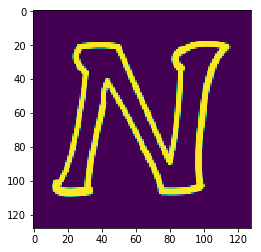

In [65]:
plt.imshow(rc[31])
print(strokes[22])

[0.0393954  0.04198318 0.04535619 0.04295604 0.04139681 0.0426881
 0.04219219 0.04184445 0.04131665 0.04173303 0.03912207 0.04308133
 0.03888666 0.04293426 0.03940537 0.04557157 0.04492381 0.04699086
 0.04061004 0.0419287  0.04248391 0.04631629 0.04701199]


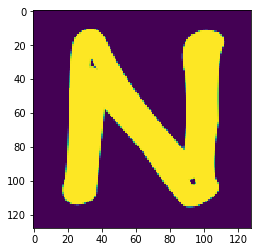

In [64]:
plt.imshow(rc[22])
print(strokes[22])

0


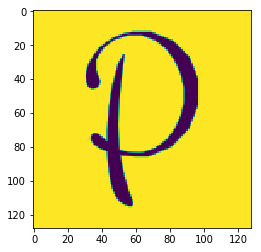

1


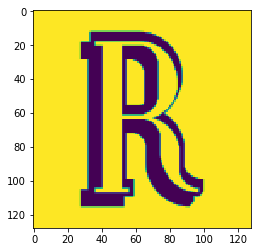

2


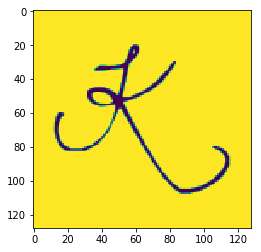

3


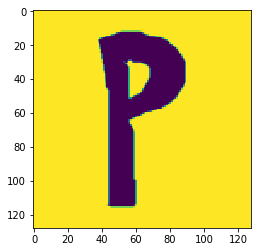

4


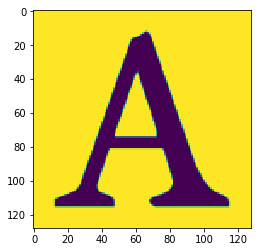

5


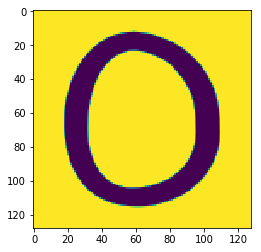

6


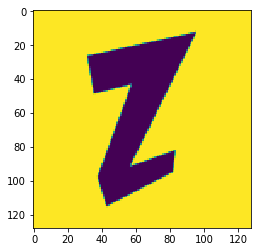

7


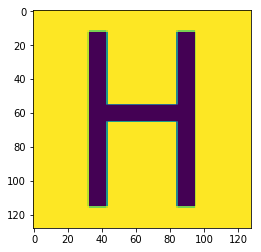

8


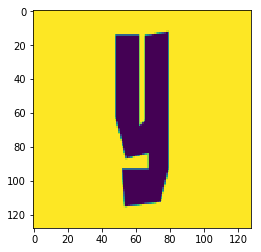

9


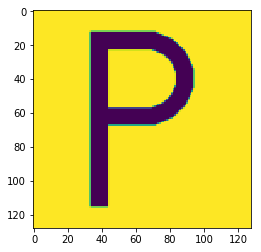

10


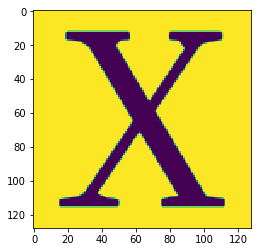

11


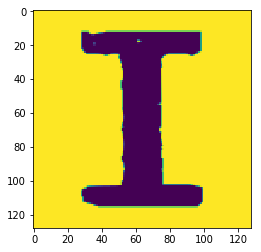

12


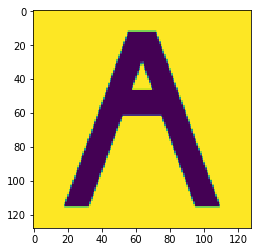

13


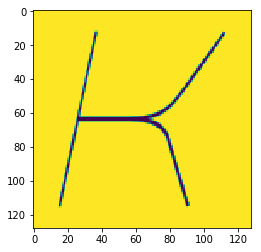

14


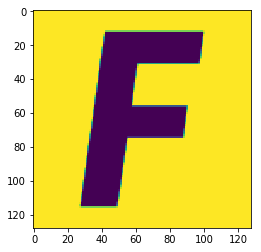

15


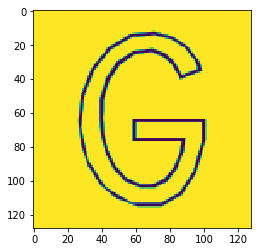

16


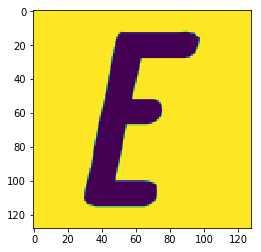

17


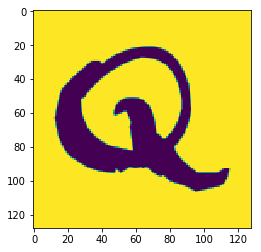

18


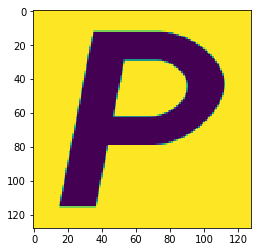

19


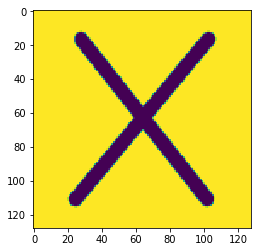

20


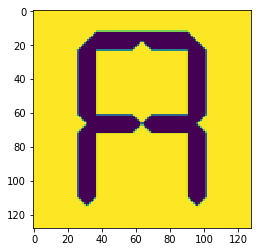

21


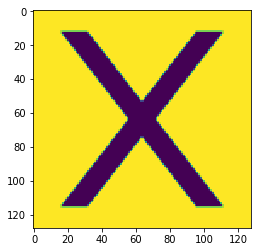

22


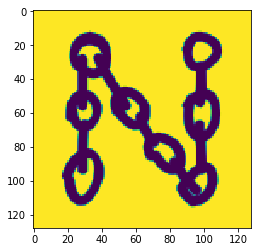

23


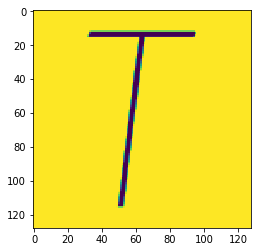

24


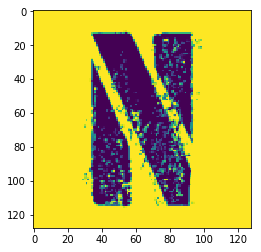

25


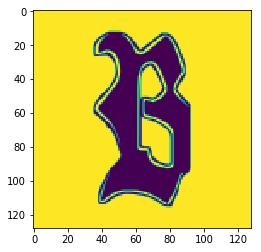

26


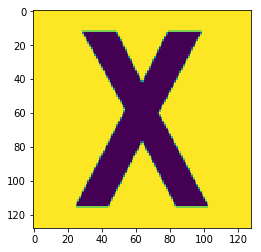

27


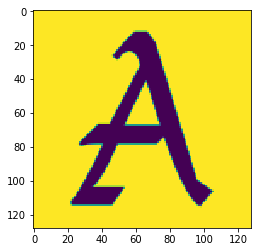

28


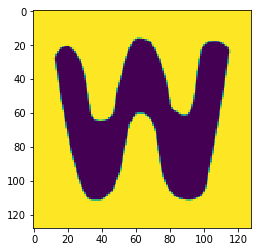

29


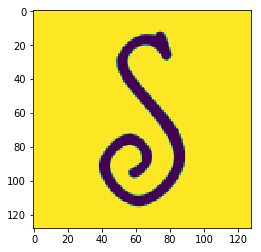

30


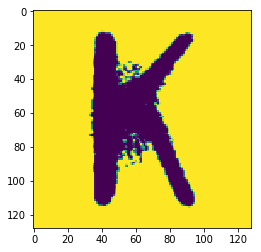

31


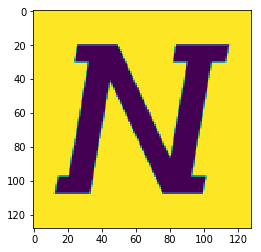

32


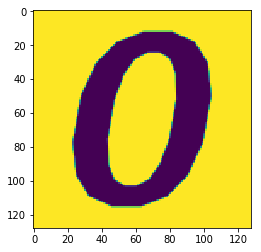

33


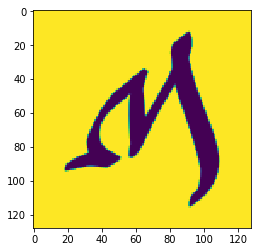

34


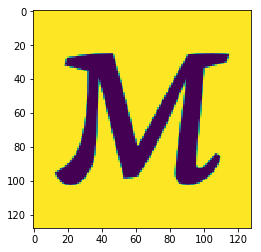

35


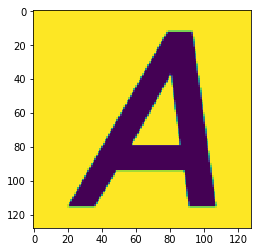

36


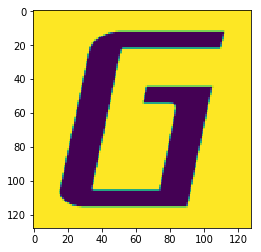

37


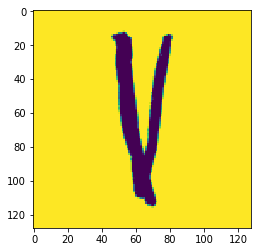

38


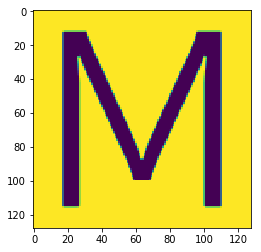

39


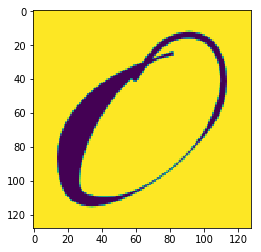

40


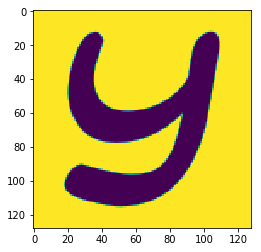

41


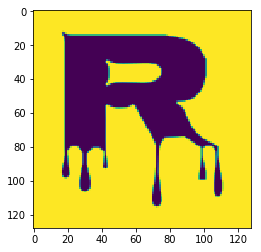

42


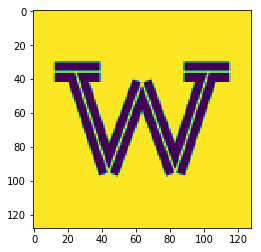

43


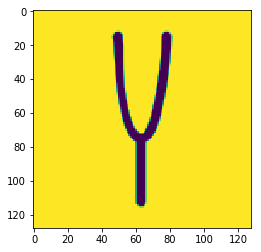

44


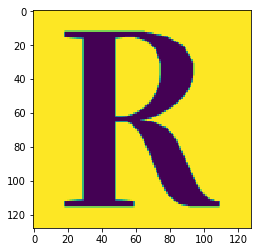

45


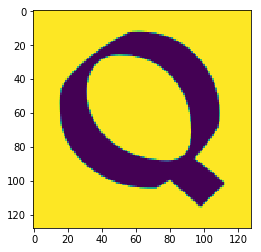

46


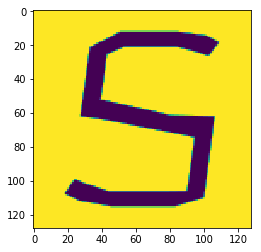

47


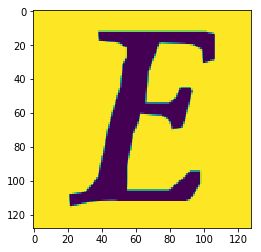

48


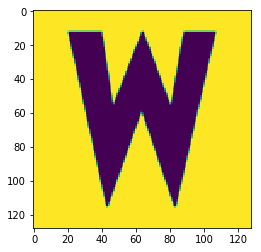

49


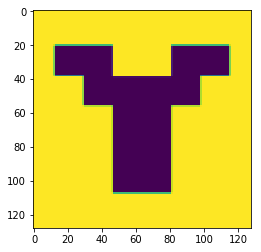

50


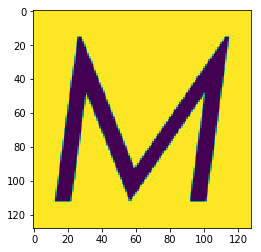

51


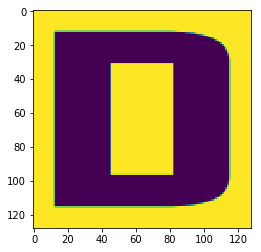

52


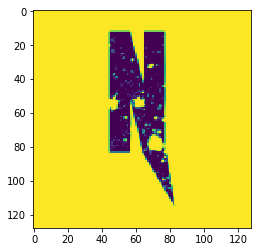

53


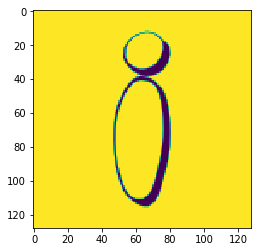

54


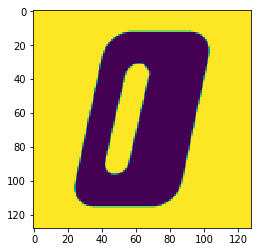

55


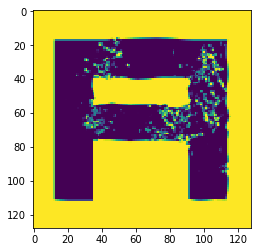

56


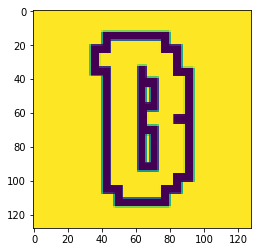

57


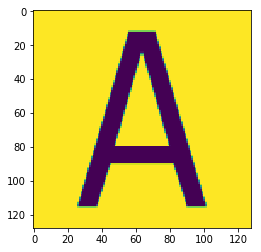

58


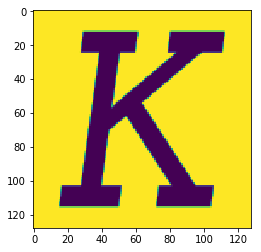

59


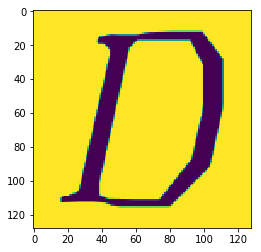

60


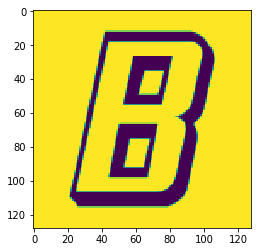

61


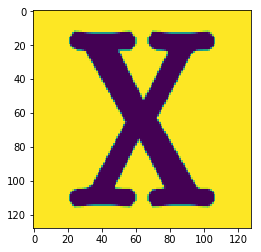

62


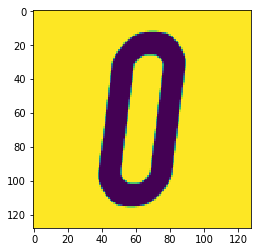

63


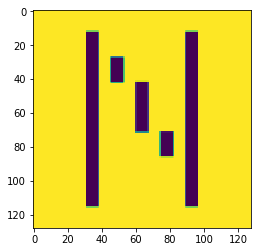

64


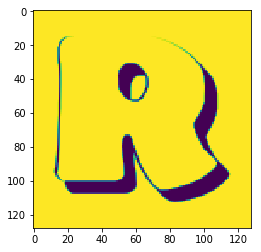

65


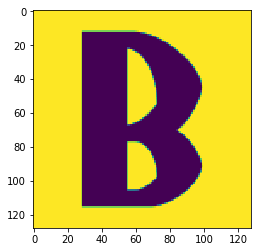

66


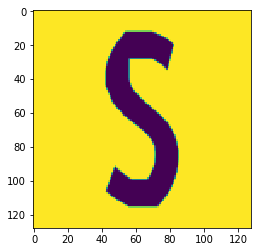

67


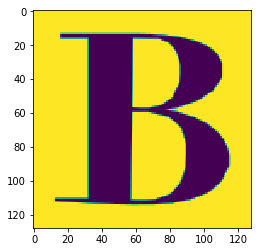

68


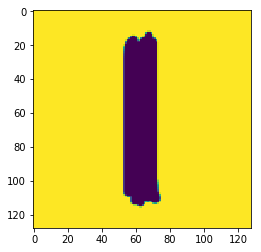

69


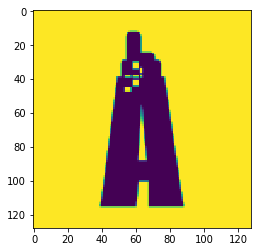

70


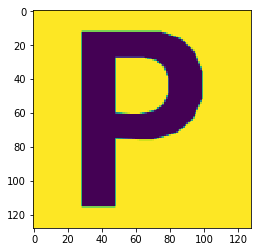

71


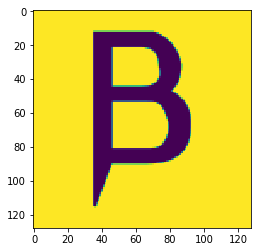

72


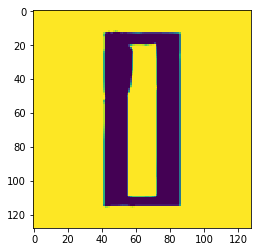

73


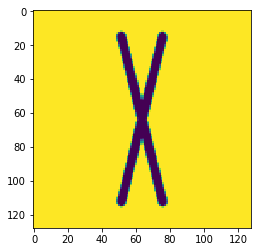

74


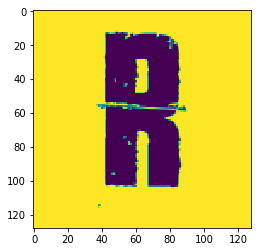

75


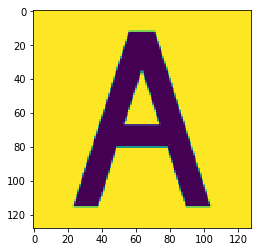

76


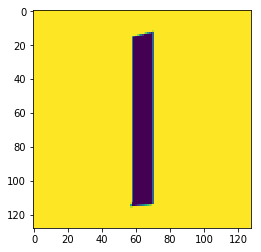

77


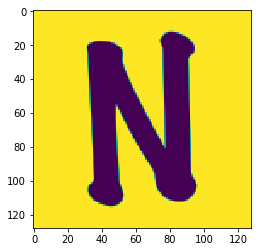

78


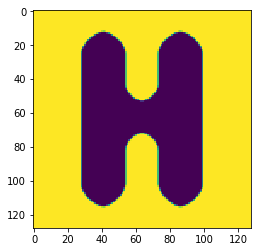

79


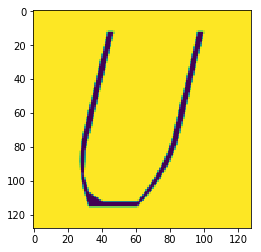

80


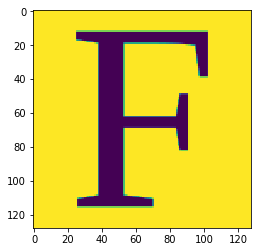

81


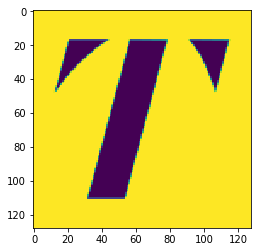

82


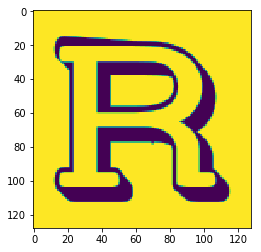

83


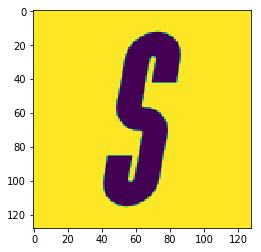

84


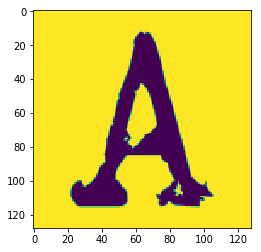

85


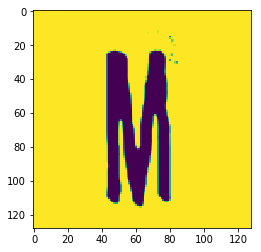

86


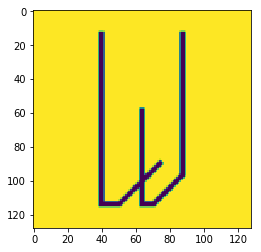

87


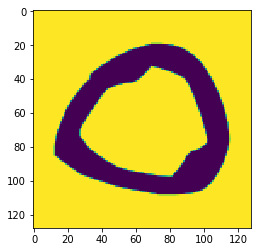

88


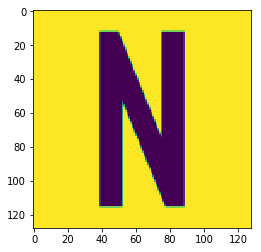

89


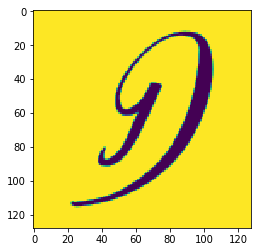

90


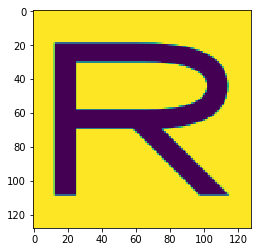

91


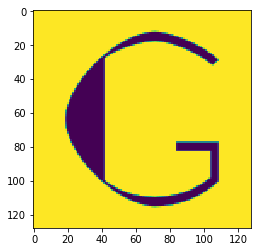

92


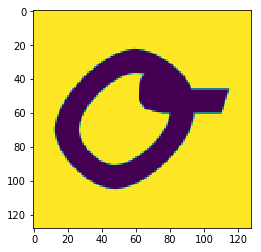

93


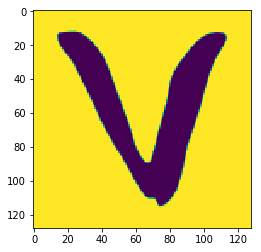

94


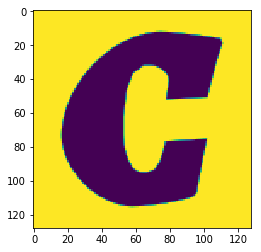

95


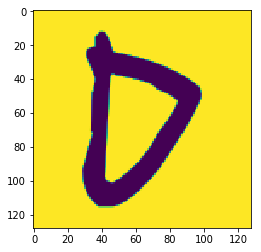

96


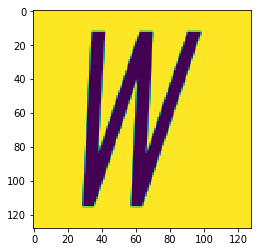

97


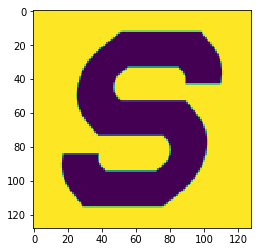

98


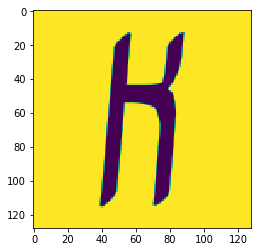

99


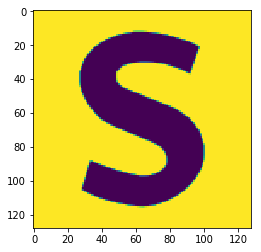

In [62]:
for i, im in enumerate(images):
    print(i)
    plt.imshow(im.squeeze())
    plt.show()

In [66]:
im1 = Image.fromarray(255*images[22].squeeze()).convert('L')
im2 = Image.fromarray(255*images[31].squeeze()).convert('L')
curves1 = Image.fromarray(255*(1-rc[22].squeeze())).convert('L')
curves2 = Image.fromarray(255*(1-rc[31].squeeze())).convert('L')
im1.save('im1.png')
im2.save('im2.png')
curves1.save('curves1.png')
curves2.save('curves2.png')